<a href="https://colab.research.google.com/github/Sabya2/Kaggle-September-TPS/blob/main/TPS_September.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and data


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
font1 = {'family':'serif','color':'brown','size':15}

# pip install missingno
import missingno as msno

# Scaling and scoring
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score

# CV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# for pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-sep-2021/train.csv')
test= pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-sep-2021/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Kaggle data/tabular-playground-series-sep-2021/sample_solution.csv')

# ID is of no use to me 
train.drop(columns = 'id', inplace = True)
test.drop(columns = 'id', inplace = True)

In [ ]:
print(train.shape)

In [ ]:
y_train = train['claim']

# Keep runtime open
(comand + option +i)

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,120000);

# EDA

## Basic Data Information

In [ ]:
print('Train Shape', train.shape, '\n', 'Test Shape', test.shape)

# too many columns
# train.describe()


Train Shape (957919, 119) 
 Test Shape (493474, 118)


No need for index, thus removed at the start

In [ ]:
print('Null in Train', train.isnull().sum().sum())
print('Null in Test', test.isnull().sum().sum())
print('Train Duplicate data', train.duplicated().sum())
print('Test Duplicate data', test.duplicated().sum())

Null in Train 1820782
Null in Test 936218
Train Duplicate data 0
Test Duplicate data 0


## Explore missing values
So there are null values in the data, need to check which columns has how many null values and what wiuld be the best way to tacklw them.

https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj, 

https://towardsdatascience.com/visualizing-the-nothing-ae6daccc9197

In [ ]:
train.isnull().sum()

f1       15247
f2       15190
f3       15491
f4       15560
f5       15405
         ...  
f115     15559
f116     15589
f117     15407
f118     15212
claim        0
Length: 119, dtype: int64

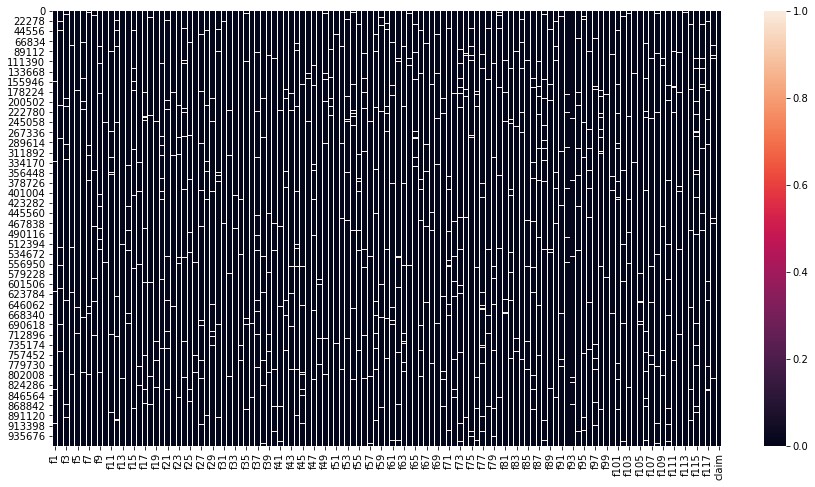

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(train.isnull(), cbar=False);

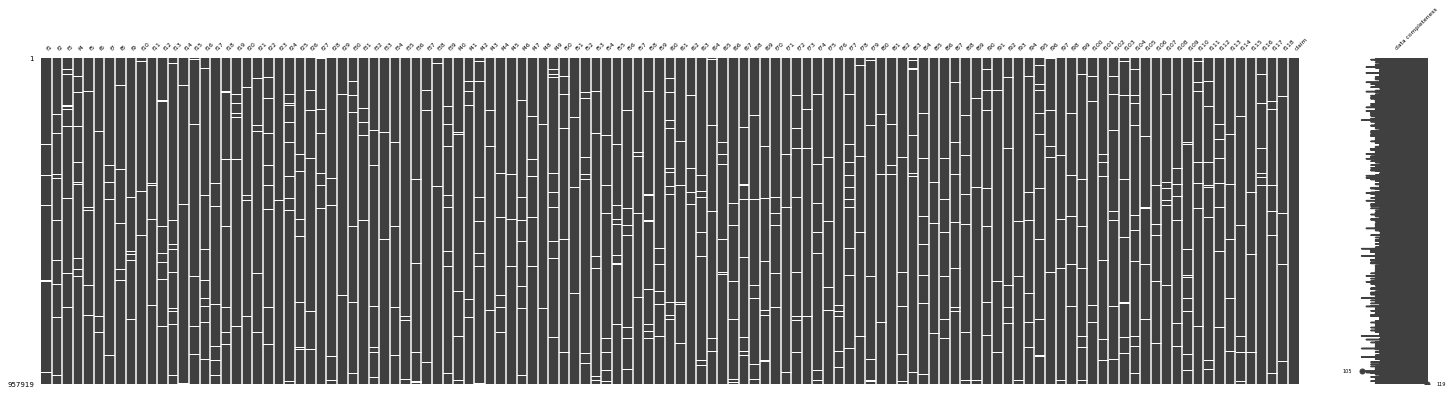

In [ ]:
msno.matrix(train, figsize=(25, 6), labels = True, fontsize = 6)

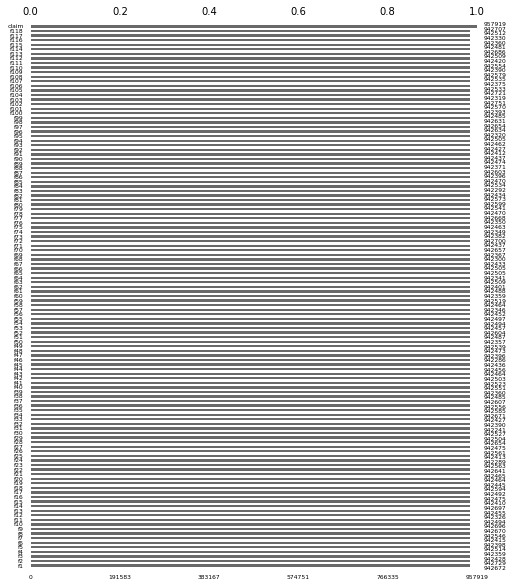

In [ ]:
msno.bar(train, figsize=(8, 10), fontsize = 6)

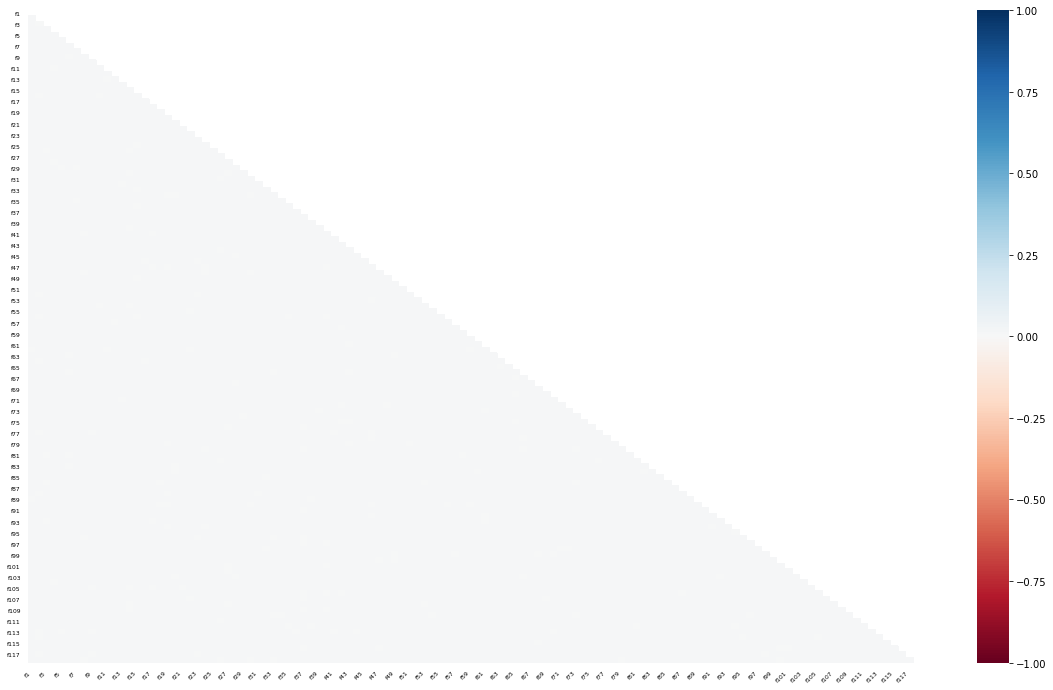

In [ ]:
msno.heatmap(train, fontsize = 6)

Claim has all the values intact. 

Rest of the columns have values missing here and there. Thus deleting rows is not an option. Need to have a good imputation logic for the missing values. Heatmap gives away the fact that missing values are not correlated with each other.

Since the data is missing at random, i'll try KNN, Statistical(mean, median) and regressional imputation, and compare them.

## Exploring variables

### Object vs Int type

In [ ]:
print(train.dtypes)

f1       False
f2       False
f3       False
f4       False
f5       False
         ...  
f115     False
f116     False
f117     False
f118     False
claim    False
Length: 119, dtype: bool


In [ ]:
c =0 
for i in range (118):
  if(train[f'f{i+1}'].dtypes == 'object'): #checking for object variable type
    print(f'f{i+1}') 
    c = c+1 # counter to keep a tally of total object variables
print('Total columns with object type variables = ',c)  

Total columns with object type variables =  0


No object variables, thus handling categorical variables is not happening this time

### Variable distribution and scaling

variable distribution with hist

box plot for outliers and variable scales

Correlation plot 

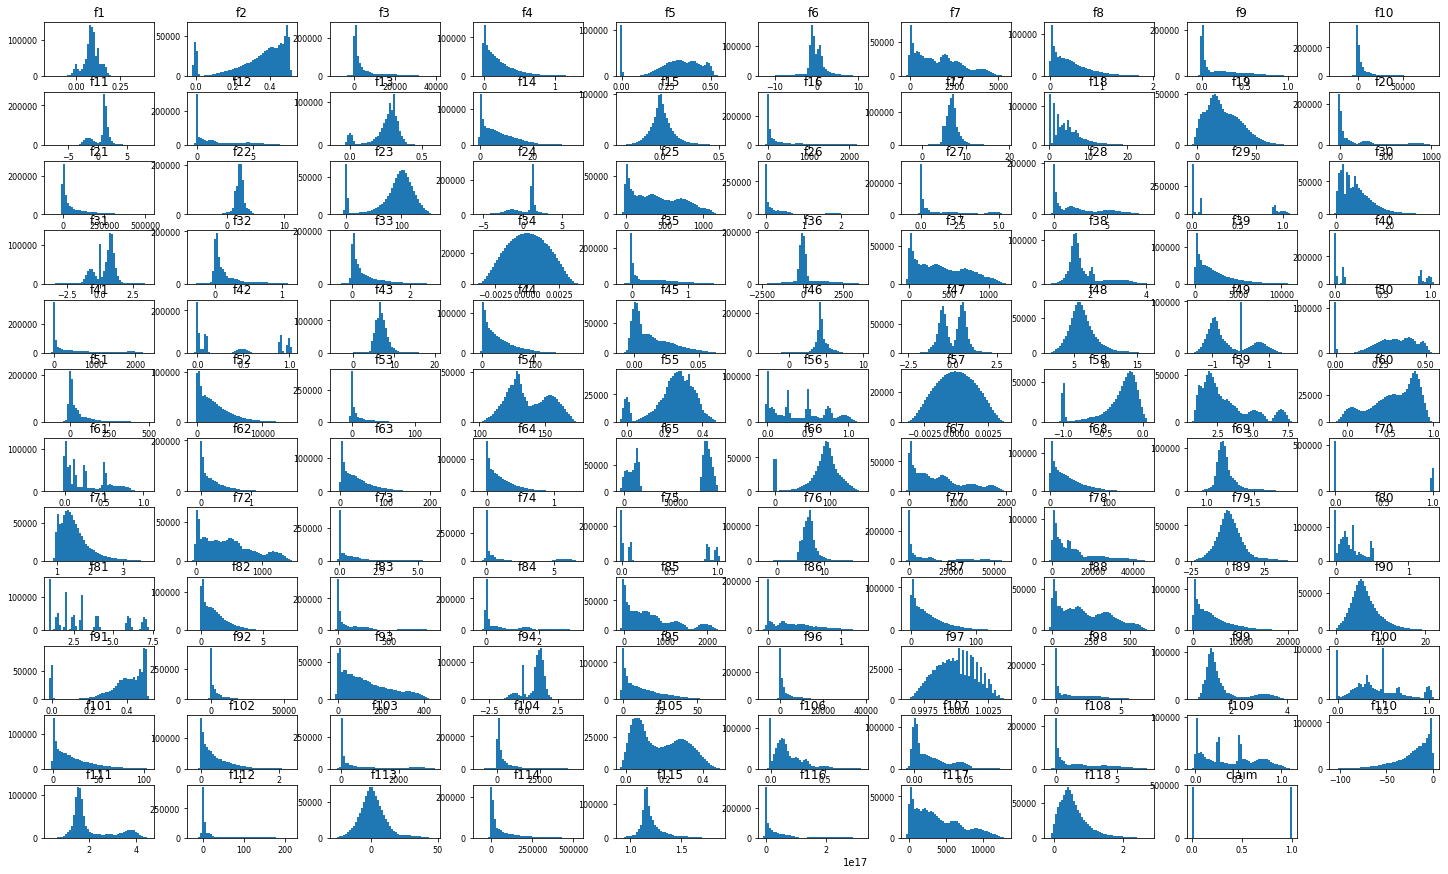

In [ ]:
plt.title('hgf')
hist = train.hist(figsize = (25, 15), bins=50, grid = False, 
                  xlabelsize=8, ylabelsize=8, layout = (12,10))

In [ ]:
fig, axes = plt.subplots(12,10,figsize=(18,15))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.histplot(data=train, x=f'f{idx+1}', 
                fill=True, 
                ax=ax, kde = True)
    # sns.kdeplot(data=test, x=f'f{idx}', 
                # fill=True, 
                # ax=ax)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx+1}', loc='right', weight='bold', fontsize=8)

fig.supxlabel('Average by class (by feature)', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

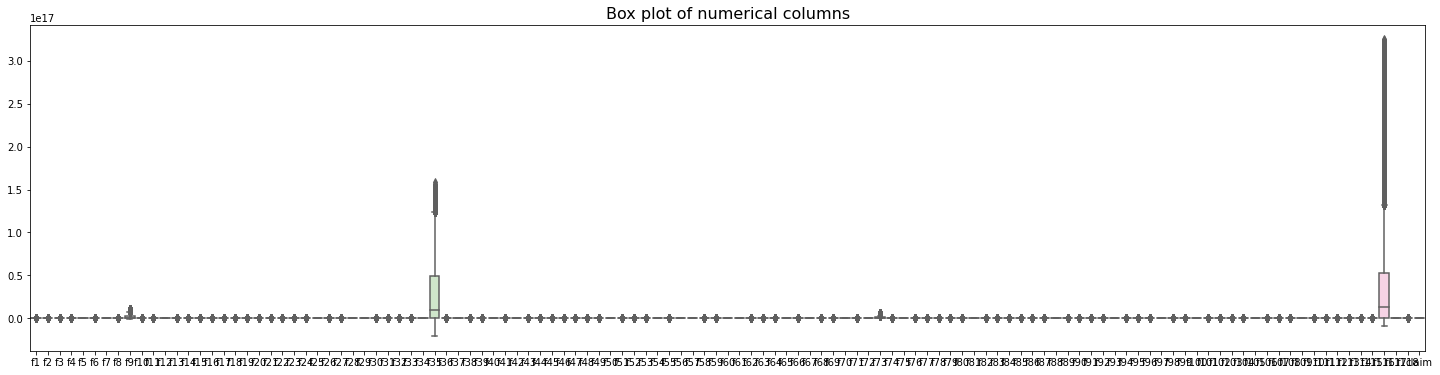

In [ ]:
plt.figure(figsize=(25,6))
ax = sns.boxplot(data=train, palette="Set3")
plt.title('Box plot of numerical columns', fontsize=16);

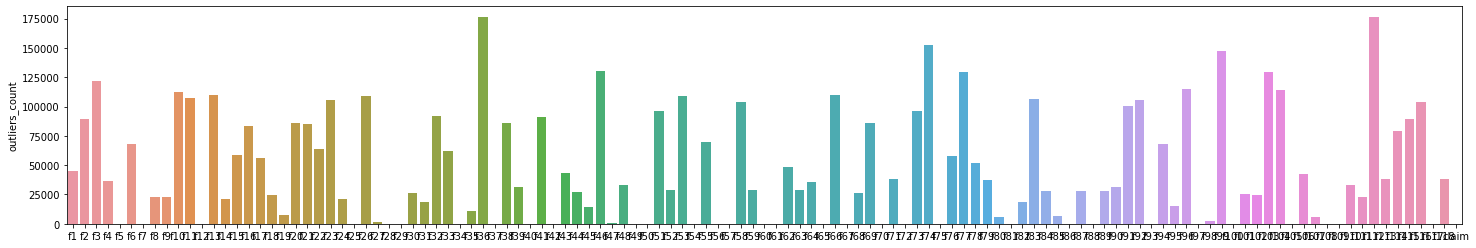

In [ ]:
# converting the describe table into a spread dataframe 
spread = pd.DataFrame(train.describe().T)

# Calculating the IQR for each feature column
IQR = spread['75%'] - spread['25%']
spread['outliers'] = ( (spread['max'] > (spread['75%'] + 1.5 * IQR)) 
                         | (spread['min'] < (spread['25%'] - 1.5 * IQR)) )

# Outliers count 
spread['outliers_count'] = ((train < (spread['25%'] - 1.5 * IQR)) 
                              | (train > (spread['75%'] + 1.5 * IQR))).sum()

plt.figure(figsize=(25,4))
ax = sns.barplot( x = spread.index, y = 'outliers_count', data=spread )

Presene of outliers and their respecrive counts. 

Also the box plot indicated scaling issues, need to reslve that before proceding further 

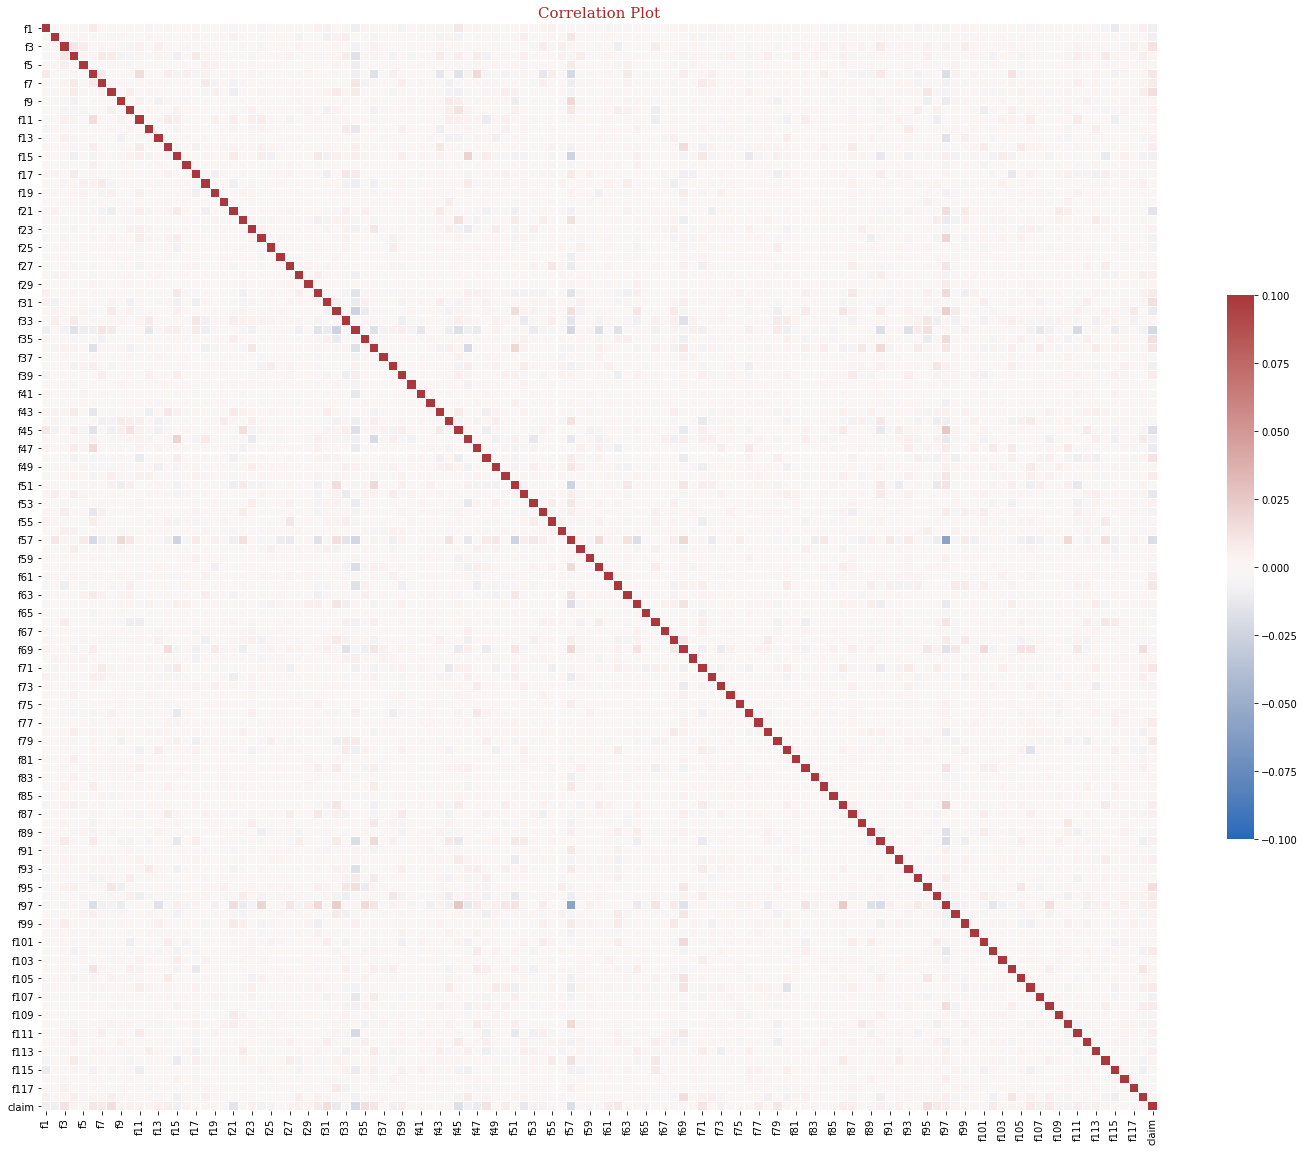

In [ ]:
# correlation matrix
font1 = {'family':'serif','color':'brown','size':15}

plt.figure(figsize=(25,20))
plt.title("Correlation Plot", fontdict = font1)
sns.heatmap(train.corr(), annot=False, cmap="vlag",  
            center = 0, linewidths=0.01, cbar_kws={"shrink": .5},
            vmin=-0.1, vmax=0.1)

Well the varibales are not related to each other. Missing value imoputation has to be random like mean, median or kNN. 

Another worry is, do i have to perform PCA, and see what happens?
lets do that 


# PCA

I have a feeling that PCA is not going to help, since the data lack highly correlated variables, still just for fun sake lets perform PCA. 

Steps for PCA are; 
* Make a copy of the main dataset to prevent any problem 
* Remove the target column 
* Missing value imputation: since the missing values are not correlated to 
each other and they are missing at random. Thus for PCA, i'll perform a simple median imputation
* Scaling of data
* Data Transformation
* Spree plot for the number of valid PC 

https://blogs.sas.com/content/iml/2019/11/04/interpret-graphs-principal-components.html
https://www.mygreatlearning.com/blog/understanding-principal-component-analysis/

https://www.geeksforgeeks.org/ml-handle-missing-data-with-simple-imputer/



In [ ]:
# A copy of train to prevent any weird thing happening to the original data
train_pca = train.copy()
train_pca.drop(columns = 'claim', inplace = True)

print('Null values before imputation' , train_pca.isnull().sum().sum())

# Missing value imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, 
                        strategy ='mean')
train_pca = pd.DataFrame(imputer.fit_transform(train_pca))

print('Null values After imputation' , train_pca.isnull().sum().sum())

Null values before imputation 1820782
Null values After imputation 0


In [ ]:
train_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117
0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.25100,135.12,168900.0,3.992400e+14,86.489,0.598810,1.423200e+09,0.27240,9.455600,-0.050305,1938.3000,8.6331,4.060700,26.86700,-1.180000,10961.00,1.5397,135.320000,-1.496500,440.080,2.590100e+12,2.194200e+09,2.968800e+06,0.001431,13.3270,0.750500,18509.0,1.468200e+05,-0.000276,1.090600e+16,1705.400,414.290000,3.5392,1888.00,0.968930,...,5.508400,-0.001081,6.1244,1.231800e+11,275.9200,5308500.0,1704.000,5.022400e+10,53.39800,-2.2012,6871.00,3.886200,-0.005580,5252.100,166.6900,1.607400,0.66534,7768.900,0.99662,1.125700e+11,2.2432,0.934160,0.65056,94569.0,21.4710,8214.100,0.288010,0.097826,0.001071,1.412400e+09,0.110930,-12.2280,1.7482,1.90960,-7.115700,4378.80,1.2096,8.613400e+14,140.100000,1.01770
1,0.100900,0.299610,11822.000,0.276500,0.459700,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,1.209300,3.334100e+09,0.28631,-0.012858,-0.019912,10.2840,6.1872,1.041900,4.64040,31.877000,123620.00,1.3951,125.810000,1.198900,136.450,9.098100e+09,4.004100e+10,1.564000e+06,0.000204,3.1074,1.503300,238000.0,2.144000e+04,-0.001344,3.079400e+16,229.100,844.820000,1.4680,4726.50,0.915380,...,-4.354600,0.254100,6.9191,1.832400e+11,9.6510,32800.0,1480.600,2.300600e+10,44.05100,205.6900,4295.30,13.388000,0.468430,754.610,83.2330,1.189000,29.55000,7343.700,0.99815,4.877700e+13,1.2708,-0.000969,5.29520,6779.0,227.7200,34.342,0.340300,0.143370,0.049276,1.903200e+09,0.976730,-56.7580,4.1684,0.34808,4.142000,913.23,1.2464,7.575100e+15,1861.000000,0.28359
2,0.178030,-0.006980,907.270,0.272140,0.459480,0.17327,2298.00,360650.0,1.224500e+13,15827.000,0.381640,1.230300e+09,0.25807,2.455600,0.019394,26.8730,7.5463,1.996700,1.95260,817.760000,-2948.70,2.0054,1.682600,1.196800,74.624,-3.273900e+10,5.718900e+10,1.105800e+04,-0.003097,8.0241,1.131800,27940.0,8.624600e+05,-0.002207,5.849100e+13,-897.840,406.072571,1.3561,3063.40,0.086232,...,4.393100,0.260260,6.1052,1.013300e+11,357.2700,1476600.0,90.845,1.306200e+09,2.37310,391.3700,2965.30,6.733556,0.494590,43.524,138.5200,1.107900,0.91948,47.915,0.99997,1.510500e+12,3.4663,0.560950,4.13090,95531.0,39.4860,-83.148,0.084881,0.032222,0.001668,1.436500e+07,0.201020,-5.7688,1.2042,0.26290,8.131200,45119.00,1.1764,3.218100e+14,3838.200000,0.40690
3,0.152360,0.007259,780.100,0.025179,0.519470,7.49140,112.51,259490.0,7.781400e+13,-36.837,1.109600,1.223100e+09,0.30944,10.370000,-0.106260,533.8400,7.8490,1.037900,8.00300,12.349000,-195.28,2.5598,92.142000,0.637890,1054.900,-1.204100e+10,5.187300e+12,1.475400e+06,1.036500,1.1903,0.989410,301200.0,3.579055e+05,-0.000007,-9.299200e+13,-10.818,1020.300000,2.9553,3342.50,-0.000372,...,9.810500,0.372830,1.5606,1.835400e+10,-3.4298,6485700.0,2120.000,3.081200e+10,34.05600,157.4300,3724.50,8.421100,0.407780,2971.200,204.7000,-0.979980,9.94050,12011.000,0.99898,5.063400e+13,1.2261,0.250200,0.72974,373690.0,194.6500,120.930,0.260710,0.234240,-0.002794,1.442300e+09,-0.011820,-34.8580,2.0694,0.79631,-16.336000,4952.40,1.1784,4.533000e+12,4889.100000,0.51486
4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.40932,2538.90,65332.0,1.907200e+15,144.120,1.053100,2.634100e+09,0.29782,2.654800,0.019394,1808.9000,7.2783,3.975700,22.44866,203.782031,29520.00,3.4225,96.725000,0.797250,215.570,1.732600e+13,2.635200e+12,2.161200e+06,0.895470,6.8257,0.974130,142620.0,2.313500e+05,0.001257,1.012500e+16,51.508,293.760000,1.3351,3042.10,0.006791,...,1.555219,0.085690,1.5846,3.825200e+10,130.7000,102100.0,1951.800,1.142800e+10,58.56600,176.8300,1279.00,4.966200,0.479120,-70.278,10.8870,1.143400,6.19120,197.470,0.99997,1.574800e+13,1.0083,0.339530,13.48600,201300.0,38.8420,324.000,0.238250,0.141550,0.002208,5.830700e+09,0.927390,-13.6410,1.5298,1.14640,-0.431240,3856.50,1.4830,-8.991300e+12,3959.2

In [ ]:
# Robust Scaling

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() 
train_pca = pd.DataFrame(scaler.fit_transform(train_pca), columns = train_pca.columns)

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_train = pca.fit_transform(train_pca)

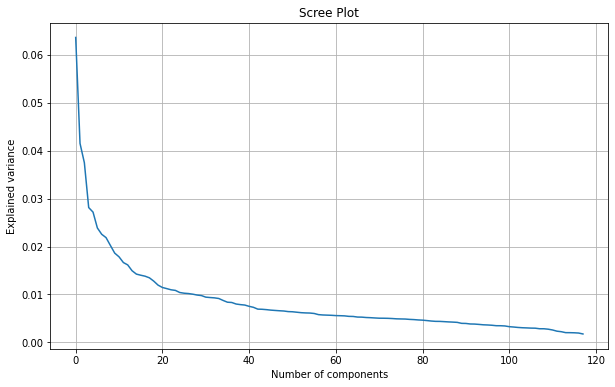

In [ ]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid()
plt.title("Scree Plot");

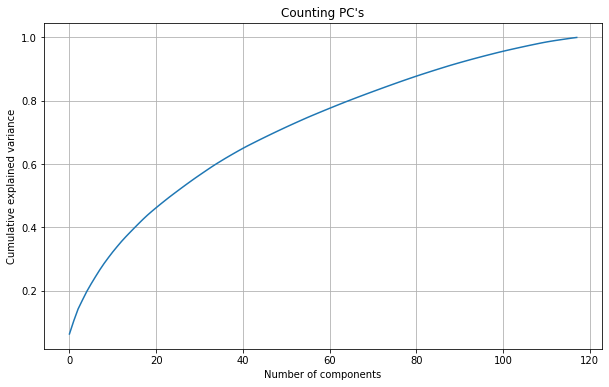

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.title("Counting PC's");

Here the scree plot indicates that 70 principal components can be explain >80% of data variance. But according to articles, i should have got lesser PC even to proceed with this approach. Still lets see. The following articles blurts out that---
https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis - "If you end up with too many principal components (more than 3), PCA might not be the best way to visualize your data. Instead, consider other dimension reduction techniques, such as t-SNE and MDS etc."
* so accordingly i'll compare PCA and try out tSNE and MDS



https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

# Data preprocession

For the pipline method, i'll perform it step by  step.

Compare the original dataset with dimensionally reduced dataset

compare different imputation techniques

compare different algorithms

https://www.geeksforgeeks.org/ml-handle-missing-data-with-simple-imputer/


https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc

https://towardsdatascience.com/step-by-step-tutorial-of-sci-kit-learn-pipeline-62402d5629b6

https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/


https://stackoverflow.com/questions/57651455/are-the-k-fold-cross-validation-scores-from-scikit-learns-cross-val-score-and


# Without pipeline - best score (0.76082)

In [ ]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [ ]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier()


In [ ]:
# parameters

num_leaves = [30, 50]

random_state = [2, 5]

In [ ]:
# Dictionary of parameters

params = {'num_leaves': num_leaves,
          'random_state': random_state
          } 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

g_search = GridSearchCV(estimator = model_lgb, param_grid = params,
                        cv = 3, n_jobs = 1, scoring = 'f1',
                        verbose = 1, return_train_score=True)

g_search.fit(x,y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 13.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=1,
             param_grid={'num_leaves': [30, 50], 'random_state': [2, 5]},
             pre_dispat

In [ ]:
print('Best parameters', g_search.best_params_)
print('Best score', (g_search.best_score_))


Best parameters {'num_leaves': 50, 'random_state': 2}
Best score 0.7608296914774383


print classification report, works when there is spliting into test and train. train will have cv and classification report on test


print(classification_report(y_test, grid_predictions)) 

In [ ]:
# for submission

submission['claim'] = g_search.predict(test) 
submission.to_csv('submission base line -lgbm classifier.csv', index = False)

# With Pipeline - score(0.763334..)

* Luckily we don't have categorical varibles, thus no pain of Encoding or missing value imputation
* For the numerical values two imputation that I want to try is 'mean' and 'KNN'


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

Preprocessing for numerical data


num_pipe_mean = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='mean')),
                                    ('scaler', RobustScaler())
                                    ])

In [ ]:
# Robust Scaling

from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler() 


In [ ]:
# determine categorical and numerical features
numerical_ix = x.select_dtypes(include=['int64', 'float64']).columns

# define the data preparation/preprocessor for the columns
t = [('num', RobustScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

In [ ]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier()
#clf.fit(X_train, y_train)

In [ ]:
# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[
                          ('prep',col_transform), 
                          ('m', model_lgb)
                           ])

In [ ]:
# parameters

n_estimators = [100, 300, 500]
num_leaves = [30, 50]
random_state = [2, 5]

In [ ]:
# Dictionary of parameters

params = {'m__n_estimators': n_estimators,
          'm__num_leaves': num_leaves,
          'm__random_state': random_state
          } 

https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline

https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once

https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

g_search = GridSearchCV(estimator = pipeline, param_grid = params,
                        cv = 3, n_jobs = 1, scoring = 'f1',
                        verbose = 1, return_train_score=True)

g_search.fit(x,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 74.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('prep',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         RobustScaler(copy=True,
                                                                                      quantile_range=(25.0,
                                                                                                      75.0),
                                                                                      with_centering=True,
                                                           

In [ ]:
print('Best parameters', g_search.best_params_)
print('Best score', (g_search.best_score_))


Best parameters {'m__n_estimators': 500, 'm__num_leaves': 50, 'm__random_state': 2}
Best score 0.7633341912087648


In [ ]:
# for submission

submission['claim'] = g_search.predict(test) 
submission.to_csv('submission base pipe line -lgbm classifier.csv', index = False)

# With pipeline 2.0 - 
* Mean imputation
* Lgbm

In [ ]:
# Splitting the data into outter and inner data

x_train, x_test, y_train, y_test = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], test_size=0.4, random_state=5)

# determine categorical and numerical features
num_ix = x_train.select_dtypes(include=['int64', 'float64']).columns

https://towardsdatascience.com/step-by-step-tutorial-of-sci-kit-learn-pipeline-62402d5629b6



In [ ]:
# define the data preparation/preprocessor for the columns
num_pipe_mean = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), 
                                ('scaler', RobustScaler()) ])

# My preprocessor
t = [('num', num_pipe_mean, num_ix)]
col_transform = ColumnTransformer(transformers=t)

In [ ]:
# model defining
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier()

# lgbm_parameters
n_estimators = [500, 800, 1000]
num_leaves = [50, 80, 100]
random_state = [5, 10]
max_depth = [5, 10, 15]


# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), 
                           ('lgbm', model_lgb)
                           ])

In [ ]:
# Dictionary of parameters
params = {'lgbm__n_estimators': n_estimators,
          'lgbm__num_leaves': num_leaves,
          'lgbm__random_state': random_state, 
          'lgbm__max_depth' : max_depth
          } 

In [ ]:
# Run the grid with pipeline
r_search = RandomizedSearchCV(estimator = pipeline, param_distributions = params, 
                              cv = 3, scoring ='f1', 
                              n_iter = 10, verbose=1, return_train_score=True)



r_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print('Best parameters', r_search.best_params_)
print('Best score', (r_search.best_score_))


In [ ]:
# Model evaluation on outer set
model_y_predict = r_search.predict(x_test) 
print('outter score for Mean imputation with lgbm', f1_score(y_test, model_y_predict))

In [ ]:
# for submission
submission['claim'] = r_search.predict(test) 
submission.to_csv('submission base pipe line - lgbm classifier - mean scalar.csv', index = False)

https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/